In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
np.random.seed(0)

In [3]:
from replay_identification.simulate import make_simulated_data

(is_replay, speed, position,
 power, spikes, time, multiunit) = make_simulated_data()

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


In [87]:
from replay_identification import SortedSpikesDetector


# detector = SortedSpikesDetector(
#     sorted_spikes_algorithm="spiking_likelihood_glm",
#     sorted_spikes_algorithm_params=dict(spike_model_penalty=1E-5, spike_model_knot_spacing=12.5),
#     discrete_state_transition_type='make_from_user_specified_diagonal',
# )
detector = SortedSpikesDetector(
    sorted_spikes_algorithm="spiking_likelihood_kde",
    discrete_state_transition_type='make_from_user_specified_diagonal',
)
detector

SortedSpikesDetector(continuous_state_transition_type='random_walk',
                     discrete_state_transition_type='make_from_user_specified_diagonal',
                     discrete_transition_diagonal=array([0.999, 0.98 ]),
                     edge_order=None, edge_spacing=None,
                     infer_track_interior=True, is_track_interior=None,
                     place_bin_size=2.0, position_range=None,
                     random_walk_variance=6.0,
                     sorted_spikes_algorithm='spiking_likelihood_kde',
                     sorted_spikes_algorithm_params={'block_size': None,
                                                     'position_std': 6.0},
                     track_graph=None)

In [88]:
detector.fit(position, spikes)

INFO:replay_identification.detectors:Fitting discrete state transition...
INFO:replay_identification.detectors:Fitting continuous state transition...
INFO:replay_identification.detectors:Fitting place fields...


SortedSpikesDetector(continuous_state_transition_type='random_walk',
                     discrete_state_transition_type='make_from_user_specified_diagonal',
                     discrete_transition_diagonal=array([0.999, 0.98 ]),
                     edge_order=None, edge_spacing=None,
                     infer_track_interior=True, is_track_interior=None,
                     place_bin_size=2.0, position_range=None,
                     random_walk_variance=6.0,
                     sorted_spikes_algorithm='spiking_likelihood_kde',
                     sorted_spikes_algorithm_params={'block_size': None,
                                                     'position_std': 6.0},
                     track_graph=None)

In [89]:
results = detector.predict(position, spikes, time)
results

INFO:replay_identification.detectors:Estimating likelihood...
100%|██████████| 8/8 [00:00<00:00, 16.14it/s]
8it [01:23, 10.44s/it]
INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...


<xarray.Dataset>
Dimensions:                (time: 97500, state: 2, position: 86)
Coordinates:
  * time                   (time) float64 0.0 0.0006667 0.001333 ... 65.0 65.0
  * position               (position) float64 0.9881 2.965 4.942 ... 167.0 169.0
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, position) float64 1.0 0.0 ... 4.254e-06
    likelihood             (time, state, position) float32 0.8569 ... 0.9958
    acausal_posterior      (time, state, position) float64 1.0 0.0 ... 4.254e-06
    non_local_probability  (time) float64 0.0 0.114 0.2139 ... 0.7526 0.7396
Attributes:
    data_log_likelihood:  -4274.818983419118

In [90]:
import seaborn as sns

def plot_results(results, time, spikes, position):
    spike_ind, neuron_ind = np.nonzero(spikes)

    fig, axes = plt.subplots(4, 1, figsize=(18, 10), sharex=True, constrained_layout=True)
    axes[0].plot(time, position)
    axes[0].set_ylabel('Linear Distance')
    axes[0].set_title('Spikes')
    axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
    axes[1].set_ylabel('Neuron Index')
    results.non_local_probability.plot(x='time', ax=axes[2], clip_on=False)
    axes[2].set_ylim((0, 1))
    axes[2].set_ylabel('Prob.')
    results.acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[3], vmin=0.0, vmax=0.05)

    axes[-1].set_xlabel('Time');
    axes[-1].set_xlim((time[0], time[-1]))

    sns.despine()

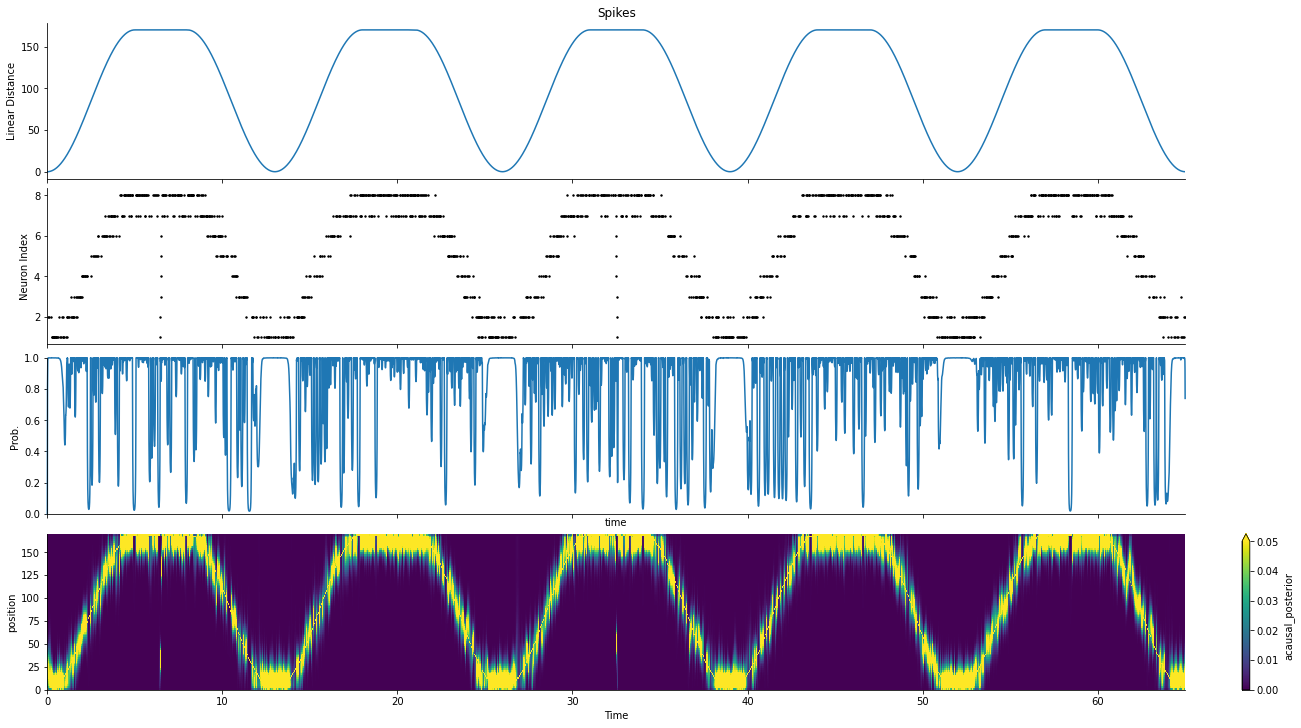

In [91]:
plot_results(results, time, spikes, position)

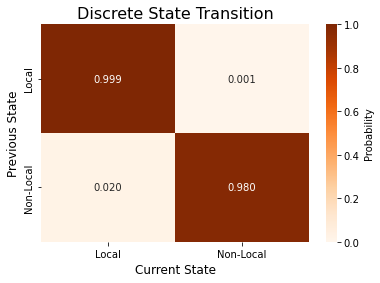

In [92]:
detector.plot_discrete_state_transition()

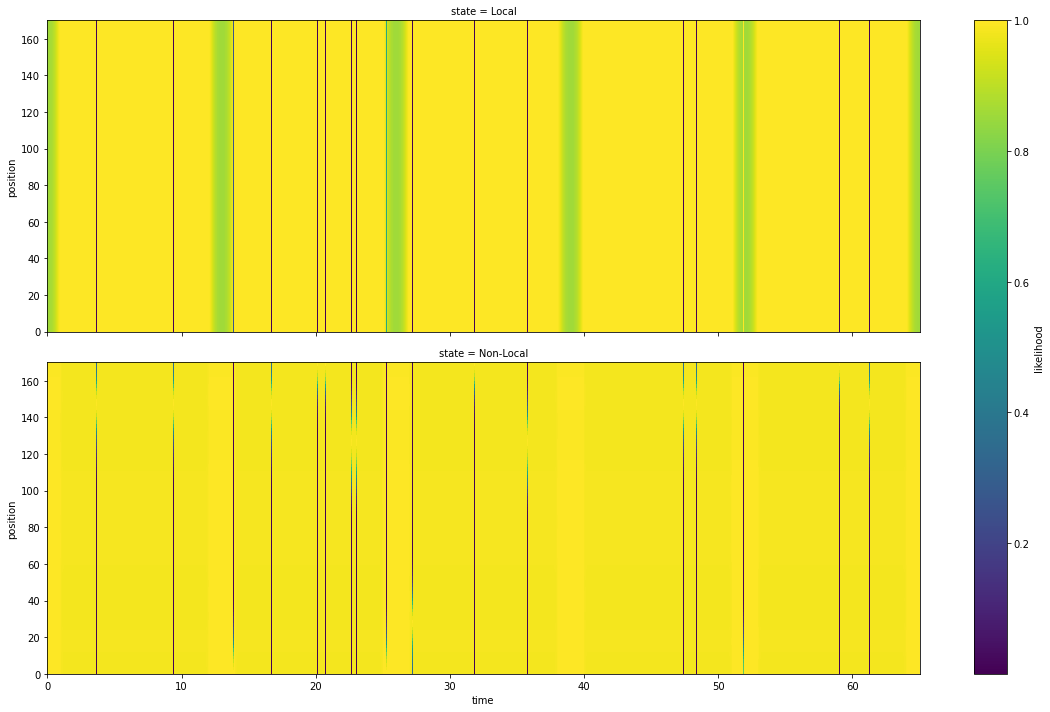

In [24]:
results.likelihood.plot(x='time', y='position', col='state', col_wrap=1, aspect=3, size=5)

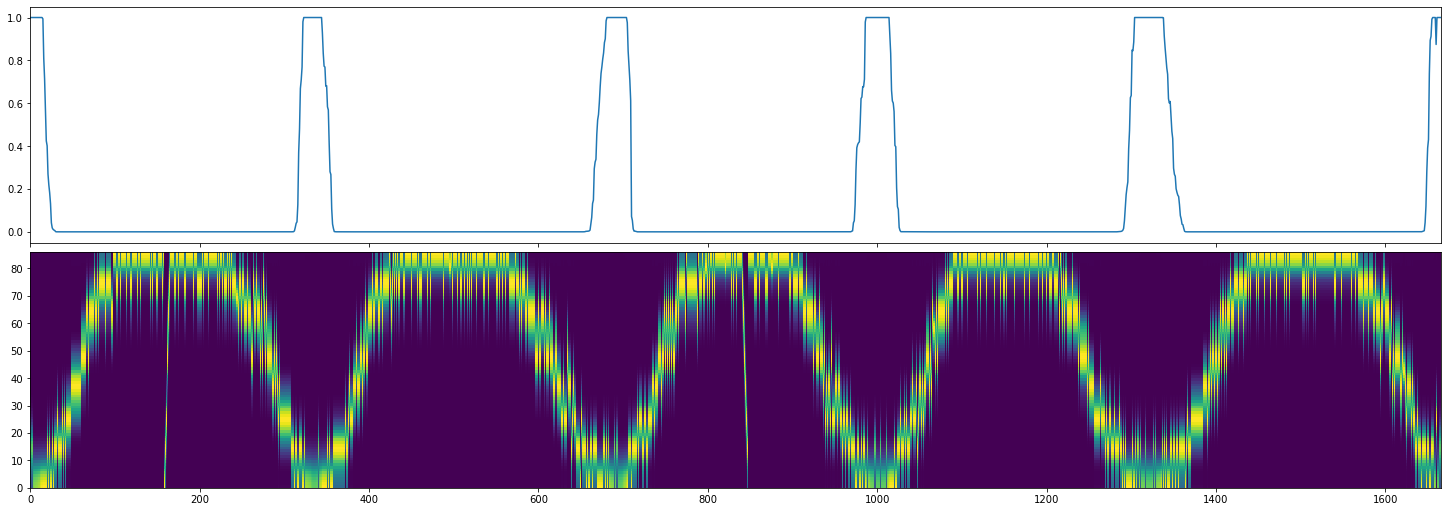

In [26]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=(20, 7))
spike_ind, neuron_ind = np.nonzero(spikes)
likelihood = results.likelihood.values
axes[0].plot(likelihood[spike_ind, 0, 0])
axes[1].pcolormesh(likelihood[spike_ind, 1].T)

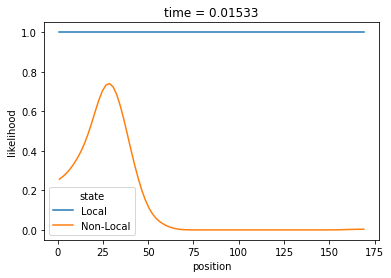

In [42]:
results.isel(time=23).likelihood.plot(x='position', hue='state')

8it [00:00, 995.39it/s]
100%|██████████| 8/8 [00:00<00:00, 5008.87it/s]


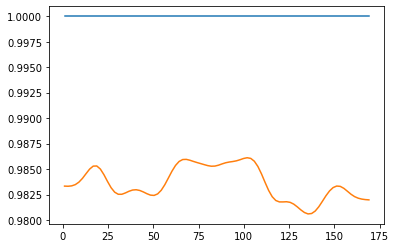

In [70]:
from replay_identification.likelihoods.spiking_likelihood_kde import estimate_non_local_spiking_likelihood, estimate_local_spiking_likelihood

n_place_bins = detector.place_bin_centers_.shape[0]
decoding_spikes = np.zeros((n_place_bins, spikes.shape[1]))

local_likelihood = estimate_local_spiking_likelihood(
    decoding_spikes,
    detector.place_bin_centers_,
    spikes,
    position,
    position_std=3.0,
    is_training=np.ones((position.shape[0])),
)

non_local_likelihood = estimate_non_local_spiking_likelihood(
    decoding_spikes[:1],
    detector.encoding_model_.keywords['place_conditional_intensity'].values,
    detector.is_track_interior_.ravel(order='F')
)

plt.plot(detector.place_bin_centers_, np.exp(local_likelihood))
plt.plot(detector.place_bin_centers_, np.exp(non_local_likelihood.T))

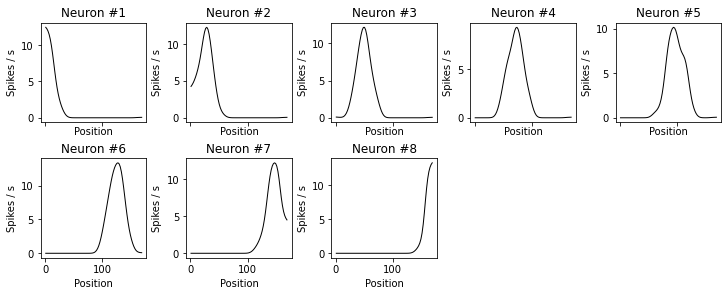

In [62]:
detector.plot_place_fields(sampling_frequency=1000)